# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import datetime

In [10]:
# using SQLite Table to read data.
con = sqlite3.connect('../Datasets/database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [11]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [12]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [13]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [14]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [16]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [18]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [20]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [21]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [22]:
reviewDF = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
reviewDF = reviewDF[:100000]

In [23]:
# Saving dataframe to make sure we are processing same dataset(Train, Test, Cv) across various models.
reviewDF.to_pickle('reviewDF')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [2]:
reviewDF = pd.read_pickle('reviewDF')

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [4]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
rLength = []
# tqdm is for printing the status bar
for sentance in tqdm(reviewDF['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    rLength.append(len(sentance.split(' ')))

100%|██████████| 100000/100000 [00:46<00:00, 2139.62it/s]


In [6]:
preprocessed_reviews[150]

'japanese version breadcrumb pan bread portuguese loan word ko child derived panko used katsudon tonkatsu cutlets served rice soups cutlets pounded chicken pork coated light crispy crumbs fried not gritty dense like regular crumbs nice deep fried shrimps decorative gourmet touch'

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='../Datasets/train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='../Datasets/train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='../Datasets/confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='../Datasets/summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [9]:
#Forming separate datafrmae
Dataset = pd.DataFrame(
    {'Review': preprocessed_reviews,
     'length': rLength,
     'Score' : reviewDF['Score']
    })
X = Dataset.iloc[:,:2].values
Y = Dataset.Score.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

X_trainText = np.array(X_train[:,:1])
X_trainText = X_trainText.reshape(X_trainText.shape[0],)

X_testText  = np.array(X_test[:,:1])
X_testText  = X_testText.reshape(X_testText.shape[0],) 

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10) 
vectorizer.fit(X_trainText)

X_train_bow = vectorizer.transform(X_trainText)
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train_bow.shape)

X_test_bow = vectorizer.transform(X_testText)
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size:  ",X_test_bow.shape)

Train Data Size:  (67000, 37640)
Test Data Size:   (33000, 37640)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [9]:
# Model Training 
clf = LogisticRegression(penalty='l1')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_bow, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


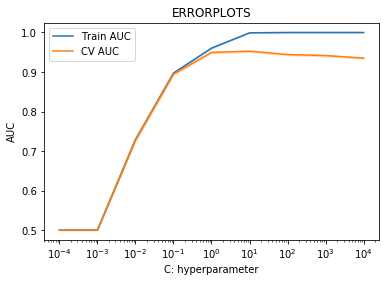

In [10]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

In [21]:
import itertools
def confusionMatrixPlot(YTest, predTest):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(YTest, predTest)
    plt.imshow(cnf_matrix,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(YTest))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cnf_matrix.max() / 2.
    for i,j in itertools.product(range(cnf_matrix.shape[0]),range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j],'d'),horizontalalignment='center',color='black' if cnf_matrix[i,j] >thresh else 'black')
    plt.show();

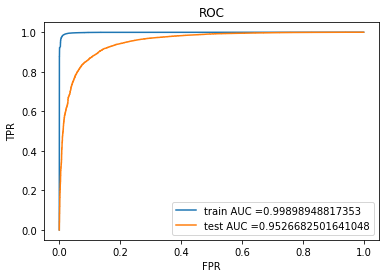

In [12]:
# Testing accuracy on test dataset
clf = LogisticRegression( C=bestParameter.C, penalty='l1')
clf.fit(X_train_bow,y_train)

predTest  = clf.predict_log_proba(X_test_bow)
predTrain = clf.predict_log_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [13]:
print("Non Zero Weights With L1: "+str(np.count_nonzero(clf.coef_)))

Non Zero Weights With L1: 7150


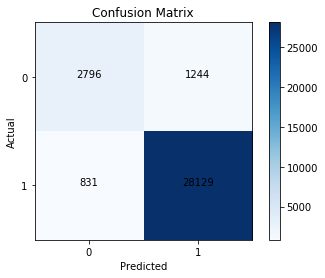

In [14]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_bow))

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [15]:
# Model Training
clf = LogisticRegression(penalty='l2')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_bow, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


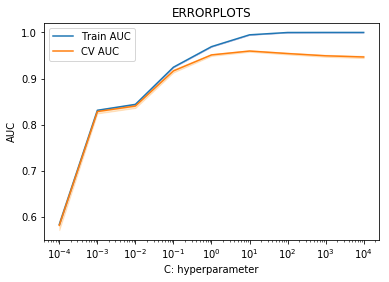

In [18]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

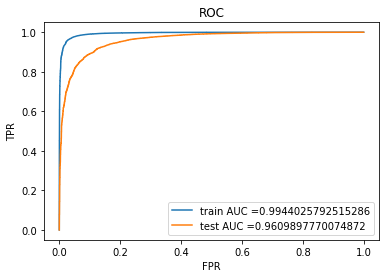

In [10]:
# Testing accuracy on test dataset
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_bow,y_train)

predTest  = clf.predict_log_proba(X_test_bow)
predTrain = clf.predict_log_proba(X_train_bow)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

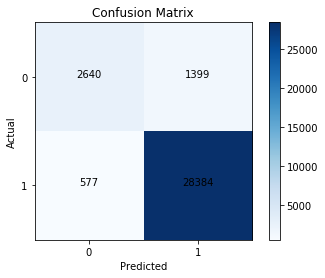

In [13]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_bow))

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [18]:
from scipy.sparse import find
XE = X_train_bow
epsilon = np.random.uniform(low = -0.0001,high = 0.0001, size = XE.size)

# Getting the postions and value of non-zero datapoints 
rw,cl,value = find(XE)

# adding small noise to train data
XE[rw,cl]   = epsilon+XE[rw,cl]

In [19]:
# Testing accuracy on test dataset
clfXE = LogisticRegression( C=bestParameter.C, penalty='l2')
clfXE.fit(XE,y_train)
predXE  = clfXE.predict_log_proba(X_test_bow)
test_fpr, test_tpr, thresholds = roc_curve(y_test, predXE[:,1])

In [20]:
weight  = np.array(clf.coef_)
weightD = np.array(clfXE.coef_)
# adding small values to weight vector to avoid divide by zero error (We need this when we use L1 regularization as sparsity is more when we use L1)
weight+= 0.000001
weightD+= 0.000001

diff = abs((weight-weightD)/weight)*100

In [21]:
# Please write all the code with proper documentation
featurePerChange = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'perChange': diff[0],
    })
sortedDiff = featurePerChange.sort_values('perChange', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [22]:
# sortedDiff =np.sort(diff)
for i in range (0,101,10):
    p = np.percentile(sortedDiff['perChange'], i)
    print(str(i)+" Percentile: "+ str(p))

0 Percentile: 4.452585142581471e-06
10 Percentile: 0.011389462398747364
20 Percentile: 0.023525325511167032
30 Percentile: 0.03671825030475792
40 Percentile: 0.051227116736127065
50 Percentile: 0.06902500589459847
60 Percentile: 0.0919338613967823
70 Percentile: 0.12551233318178578
80 Percentile: 0.1871405182884357
90 Percentile: 0.37401303119628193
100 Percentile: 537.5863349726857


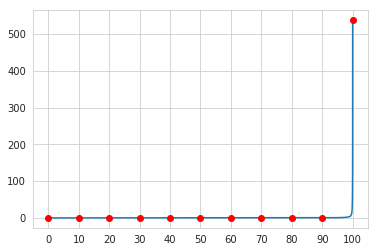

In [71]:
y = np.array(sortedDiff['perChange'])

# Percentile values
x = np.array([i for i in range(0,101,10)])

percentile = mlab.prctile(y, p=x)
plt.plot(y)

# Place red dots on the percentiles
plt.plot((len(y)-1) * x/100., percentile, 'ro')

# Set tick locations and labels
plt.xticks((len(y)-1) * x/100., map(str, x))

plt.show()

In [43]:
np.percentile(sortedDiff['perChange'], 99.97)

101.52054115560091

In [44]:
np.percentile(sortedDiff['perChange'], 99.98)

166.244598761709

From above percentiles graph we can identify that the features weight difference increases drastically after 101 i.e around 99th percentile. So we can set threshold as 101 to identify collinear feature.

In [62]:
# Collinear features
colFeatures = sortedDiff[sortedDiff['perChange']>101]['feature']
print(colFeatures.to_string(index=False))

    well bought
          tried
    loved would
       fun gift
     use cereal
      not begin
 dried apricots
     noticeably
      nostalgic
   made another
 worth purchase
   tried amazon
       vitacoco


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [88]:
# Please write all the code with proper documentation
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf.coef_[0],
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [89]:
# Top 10 positive features
sortedFeature[-15:]

,feature,Probability
337,addictive,7.056324
29888,smooth,7.265036
37557,yummy,7.368799
2626,best,7.725455
14426,great,8.110959
1884,awesome,8.202065
22054,not bitter,8.238804
19139,loves,8.420771
24704,perfect,8.479863
10332,excellent,8.667962


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [90]:
# Top 10 negative features
sortedFeature[:15]

,feature,Probability
37076,worst,-15.412821
22771,not worth,-14.086195
8490,disappointing,-13.570262
22554,not recommend,-11.207442
34920,two stars,-11.065558
33261,terrible,-10.963824
8492,disappointment,-10.436350
8474,disappointed,-10.006179
15751,horrible,-9.891593
3224,bland,-9.552406


### Feature Engineering

In [23]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_bow_newF = sparse.hstack((X_train_bow,reviewLen))
X_train_bow_newF = preprocessing.normalize(X_train_bow_newF)
print("Old Dimension: "+str(X_train_bow.shape))
print("New Dimension: "+ str(X_train_bow_newF.shape))

Old Dimension: (67000, 37572)
New Dimension: (67000, 37573)


In [24]:
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_bow_newF = sparse.hstack((X_test_bow,reviewLen))
X_test_bow_newF = preprocessing.normalize(X_test_bow_newF)
print("Old Dimension: "+str(X_test_bow.shape))
print("New Dimension: "+ str(X_test_bow_newF.shape))

Old Dimension: (33000, 37572)
New Dimension: (33000, 37573)


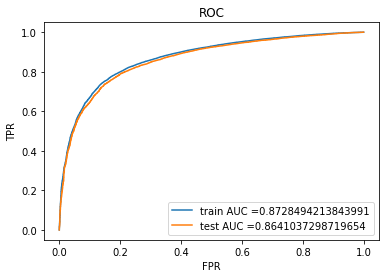

In [25]:
# Testing accuracy on new test dataset
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_bow_newF,y_train)


predTest  = clf.predict_log_proba(X_test_bow_newF)
predTrain = clf.predict_log_proba(X_train_bow_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

#### Observarion:
    - Model accuracy drops to 86% after adding review length as a new feature.

# [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [26]:
# Please write all the code with proper documentation
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train_tfidf.shape)

X_test_tfidf = vectorizer.transform(X_testText)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_train_tfidf.shape)

Train Data Size:  (67000, 37572)
Test Data Size:  (67000, 37572)


### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [27]:
# Model Training
clf = LogisticRegression(penalty='l1')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring="roc_auc")
model.fit(X_train_tfidf, y_train)

bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


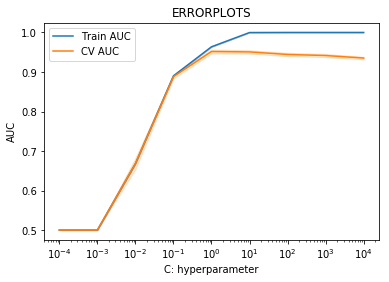

In [28]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

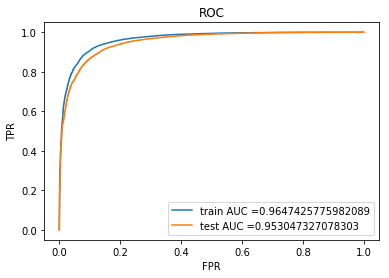

In [29]:
# Testing accuracy on test dataset with L1 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l1')
clf.fit(X_train_tfidf,y_train)


predTest  = clf.predict_log_proba(X_test_tfidf)
predTrain = clf.predict_log_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

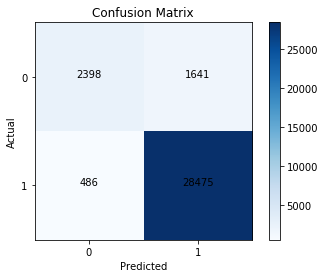

In [30]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_tfidf))

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [32]:
# Model Training
clf = LogisticRegression(penalty='l2')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring="roc_auc")
model.fit(X_train_tfidf, y_train)

bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


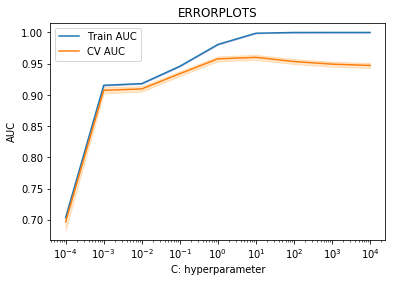

In [33]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

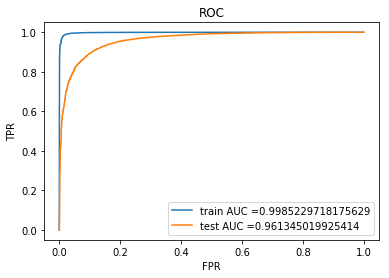

In [34]:
# Testing accuracy on test dataset with L1 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_tfidf,y_train)


predTest  = clf.predict_log_proba(X_test_tfidf)
predTrain = clf.predict_log_proba(X_train_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

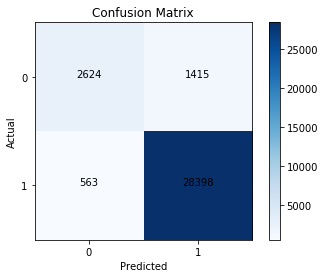

In [35]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_tfidf))

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [36]:
# Please write all the code with proper documentation
featureProb = pd.DataFrame(
    {'feature': vectorizer.get_feature_names(),
     'Probability': clf.coef_[0],
    })

sortedFeature = featureProb.sort_values('Probability', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [37]:
# Top 10 positive features
sortedFeature[-15:]

,feature,Probability
32608,tasty,8.003683
21528,nice,8.100004
1002,amazing,8.560562
25004,pleased,8.626914
10819,favorite,9.050243
18728,love,9.309159
36866,wonderful,10.170051
19019,loves,10.296372
10250,excellent,10.744488
13699,good,10.937428


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [38]:
# Top 10 negative features
sortedFeature[:15]

,feature,Probability
37047,worst,-14.724359
22662,not worth,-14.407628
8417,disappointed,-13.795239
8433,disappointing,-12.535007
22448,not recommend,-11.362710
34876,two stars,-11.200230
33224,terrible,-10.198009
8434,disappointment,-10.039228
21900,not,-10.025190
34991,unfortunately,-9.513703


### Feature Engineering

In [39]:
# Adding review length to the train dataset
reviewLen = pd.to_numeric((X_train[:,-1:]).reshape(X_train.shape[0],))
reviewLen = reviewLen.reshape(X_train.shape[0],1)
X_train_tfidf_newF = sparse.hstack((X_train_tfidf,reviewLen))
X_train_tfidf_newF = preprocessing.normalize(X_train_tfidf_newF)
print("Old Dimension: "+str(X_train_tfidf.shape))
print("New Dimension: "+ str(X_train_tfidf_newF.shape))
print("------------------------------")
# Adding review length to the test dataset
reviewLen = pd.to_numeric((X_test[:,-1:]).reshape(X_test.shape[0],))
reviewLen = reviewLen.reshape(X_test.shape[0],1)
X_test_tfidf_newF = sparse.hstack((X_test_tfidf,reviewLen))
X_test_tfidf_newF = preprocessing.normalize(X_test_tfidf_newF)
print("Old Dimension: "+str(X_test_tfidf.shape))
print("New Dimension: "+ str(X_test_tfidf_newF.shape))

Old Dimension: (67000, 37572)
New Dimension: (67000, 37573)
------------------------------
Old Dimension: (33000, 37572)
New Dimension: (33000, 37573)


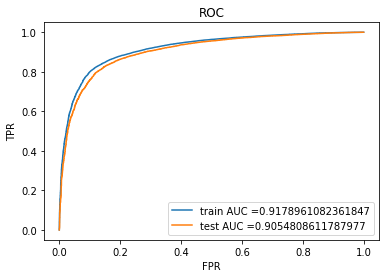

In [40]:
# Testing accuracy on new test dataset
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_tfidf_newF,y_train)

predTest  = clf.predict_log_proba(X_test_tfidf_newF)
predTrain = clf.predict_log_proba(X_train_tfidf_newF)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

#### Observarion:
    - Model accuracy drops to 90% after adding review length as a extra feature.
    - Accuracy drop is comparatively better than the model trained over BOW. 

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [10]:
# Train your own Word2Vec model using your own text corpus
def sentenceSplit(data):
    list_of_sentance=[]
    for sentance in data:
        list_of_sentance.append(sentance.split())
    return list_of_sentance

In [11]:
# this line of code trains your w2v model on the give list of sentances
list_of_sentance_train = sentenceSplit(X_trainText)
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=150, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [12]:
def avgW2V(list_of_sentance,W2VModel):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(150) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in W2VModel:
                vec = W2VModel.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [13]:
# Vectorizing Train and Test data
# Training Data
X_train_w2v = avgW2V(list_of_sentance_train, w2v_model)

# Test Data
list_of_sentance_test = sentenceSplit(X_testText)
X_test_w2v = avgW2V(list_of_sentance_test, w2v_model)

100%|██████████| 33000/33000 [00:14<00:00, 2355.61it/s]


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [14]:
# Model Training
clf = LogisticRegression(penalty='l1')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_w2v, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


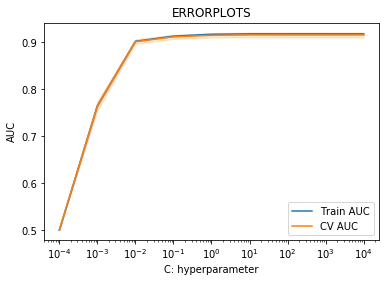

In [15]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score']
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

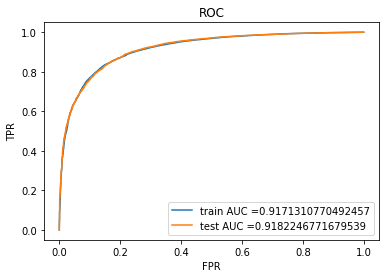

In [16]:
# Testing accuracy on test dataset with L1 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l1')
clf.fit(X_train_w2v,y_train)

predTest  = clf.predict_log_proba(X_test_w2v)
predTrain = clf.predict_log_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

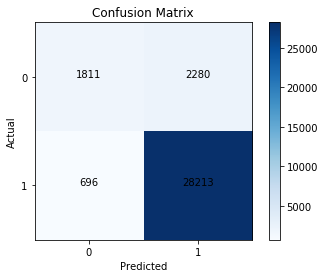

In [18]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_w2v))

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [17]:
# Model Training
clf = LogisticRegression(penalty='l2')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_w2v, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


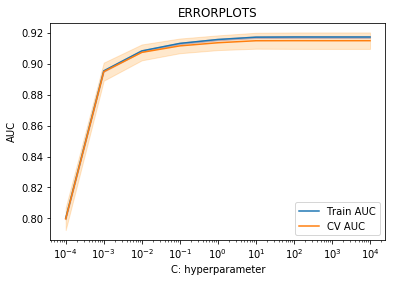

In [18]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score']
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

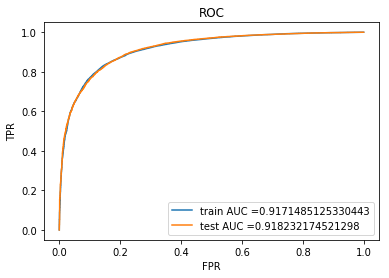

In [19]:
# Testing accuracy on test dataset with L1 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_w2v, y_train)

predTest  = clf.predict_log_proba(X_test_w2v)
predTrain = clf.predict_log_proba(X_train_w2v)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

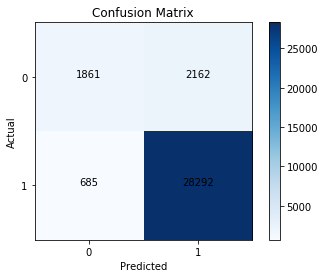

In [22]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_w2v))

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [23]:
# Vectorization of train and test review
vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10)
vectorizer.fit(X_trainText)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_trainText:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_testText:
    sent_of_test.append(sent.split()) 

In [24]:
# TFIDF-Word2Vec for training data.
tfidf_feat = vectorizer.get_feature_names()
X_train_tfidf = vectorizer.transform(X_trainText)
X_train_tfidf_AW2V = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_AW2V.append(sent_vec)
    row += 1

100%|██████████| 67000/67000 [57:40<00:00, 19.36it/s]  


In [25]:
# TFIDF-Word2Vec for test data .
from tqdm import tqdm_notebook as tqdm

X_test_tfidf_AW2V = []; 
X_test_tfidf = vectorizer.transform(X_testText)
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(150) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_AW2V.append(sent_vec)
    row += 1

In [26]:
X_train_tfidf_AW2V = preprocessing.normalize(X_train_tfidf_AW2V) 
X_test_tfidf_AW2V = preprocessing.normalize(X_test_tfidf_AW2V)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [27]:
# Model Training
clf = LogisticRegression(penalty='l1')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_tfidf_AW2V, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


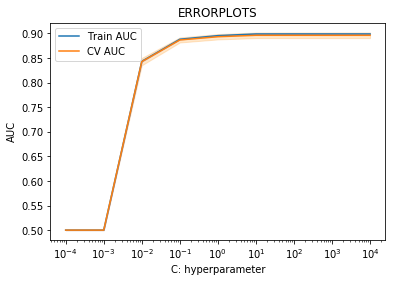

In [28]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

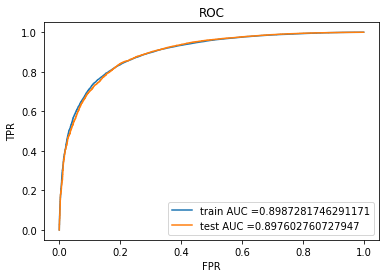

In [29]:
# Testing accuracy on test dataset with L1 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l1')
clf.fit(X_train_tfidf_AW2V,y_train)

predTest  = clf.predict_log_proba(X_test_tfidf_AW2V)
predTrain = clf.predict_log_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

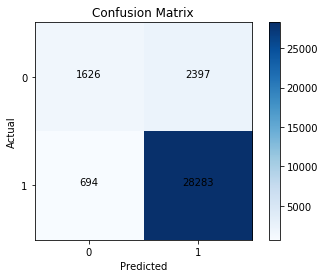

In [30]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_tfidf_AW2V))

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [35]:
# Model Training
clf = LogisticRegression(penalty='l2')
parameters = [{'C': np.logspace(-4,4,9)}]
model = GridSearchCV(clf, parameters, cv=10, scoring='roc_auc')
model.fit(X_train_tfidf_AW2V, y_train)
bestParameter = model.best_estimator_
print("Best Hyperparameter: "+ str(bestParameter))

Best Hyperparameter: LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


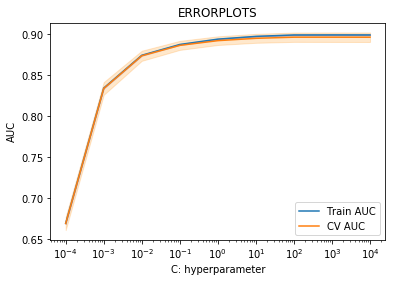

In [36]:
# Train vs CV AUC plot
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

C = np.logspace(-4,4,9)
plt.semilogx(C, train_auc, label='Train AUC')

# this code is copied farom here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERRORPLOTS")
plt.show()

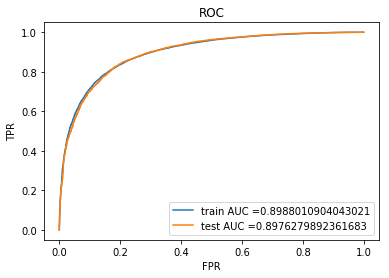

In [37]:
# Testing accuracy on test dataset with L2 regularization
clf = LogisticRegression( C=bestParameter.C, penalty='l2')
clf.fit(X_train_tfidf_AW2V,y_train)

predTest  = clf.predict_log_proba(X_test_tfidf_AW2V)
predTrain = clf.predict_log_proba(X_train_tfidf_AW2V)

train_fpr, train_tpr, thresholds = roc_curve(y_train, predTrain[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, predTest[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

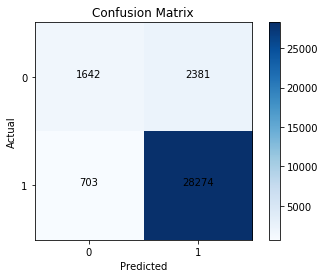

In [38]:
# Confusion Matrix
confusionMatrixPlot(y_test,clf.predict(X_test_tfidf_AW2V))

# [6] Conclusions

In [6]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter:C", "AUC","Penalty"]
x.add_row(["BOW", "Logistic Regression", 10, 0.9526,"L1"])
x.add_row(["BOW", "Logistic Regression", 10, 0.9609,"L2"])

x.add_row(["TFIDF", "Logistic Regression", 1, 0.9530, "L1"])
x.add_row(["TFIDF", "Logistic Regression", 10, 0.9613, "L2"])

x.add_row(["Average W2v", "Logistic Regression",10, 0.9182, "L1"])
x.add_row(["Average W2v", "Logistic Regression",100, 0.9182, "L2"])

x.add_row(["TFIDF-W2v", "Logistic Regression", 10, 0.8976,"L1"])
x.add_row(["TFIDF-W2v", "Logistic Regression", 1000, 0.8976,"L1"])
print(x)

+-------------+---------------------+------------------+--------+---------+
|  Vectorizer |        Model        | Hyperparameter:C |  AUC   | Penalty |
+-------------+---------------------+------------------+--------+---------+
|     BOW     | Logistic Regression |        10        | 0.9526 |    L1   |
|     BOW     | Logistic Regression |        10        | 0.9609 |    L2   |
|    TFIDF    | Logistic Regression |        1         | 0.953  |    L1   |
|    TFIDF    | Logistic Regression |        10        | 0.9613 |    L2   |
| Average W2v | Logistic Regression |        10        | 0.9182 |    L1   |
| Average W2v | Logistic Regression |       100        | 0.9182 |    L2   |
|  TFIDF-W2v  | Logistic Regression |        10        | 0.8976 |    L1   |
|  TFIDF-W2v  | Logistic Regression |       1000       | 0.8976 |    L1   |
+-------------+---------------------+------------------+--------+---------+
